# Setup

In [16]:
#Montage du disque
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Clone repo, install dependencies and check PyTorch and GPU.

In [17]:
#%cd '/home/utilisateur/VSCode/FullStack/9. Personal project/'
%pip install wandb
!git clone https://github.com/ultralytics/yolov5  # clone

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Cloning into 'yolov5'...
remote: Enumerating objects: 12189, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 12189 (delta 22), reused 20 (delta 8), pack-reused 12140
Receiving objects: 100% (12189/12189), 12.63 MiB | 16.39 MiB/s, done.
Resolving deltas: 100% (8384/8384), done.


In [18]:
%cd yolov5
%pip install -qr requirements.txt  # install

/content/yolov5


In [19]:
%cd /content/yolov5

/content/yolov5


In [20]:
import torch
#import utils
#display = utils.notebook_init()
from IPython.display import Image  # for displaying images
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

random.seed(108)

Move to dataset folder

In [21]:
#Montage du disque
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
%mkdir RoadDamageDataset 
%cd RoadDamageDataset

# train set
!wget -c https://mycityreport.s3-ap-northeast-1.amazonaws.com/02_RoadDamageDataset/public_data/IEEE_bigdata_RDD2020/train.tar.gz

# test1 set
#!wget -c https://mycityreport.s3-ap-northeast-1.amazonaws.com/02_RoadDamageDataset/public_data/IEEE_bigdata_RDD2020/test1.tar.gz

# + test2 set will be released on 10th, September
# test1 set
#!wget -c https://mycityreport.s3-ap-northeast-1.amazonaws.com/02_RoadDamageDataset/public_data/IEEE_bigdata_RDD2020/test2.tar.gz

!tar xf train.tar.gz
#!tar xf test1.tar.gz
#!tar xf test2.tar.gz

/content/yolov5/RoadDamageDataset
--2022-09-04 13:43:18--  https://mycityreport.s3-ap-northeast-1.amazonaws.com/02_RoadDamageDataset/public_data/IEEE_bigdata_RDD2020/train.tar.gz
Resolving mycityreport.s3-ap-northeast-1.amazonaws.com (mycityreport.s3-ap-northeast-1.amazonaws.com)... 52.219.196.42
Connecting to mycityreport.s3-ap-northeast-1.amazonaws.com (mycityreport.s3-ap-northeast-1.amazonaws.com)|52.219.196.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1472626254 (1.4G) [application/x-tar]
Saving to: ‘train.tar.gz’

train.tar.gz        100%[===================>]   1.37G  12.5MB/s    in 1m 54s  

2022-09-04 13:45:13 (12.3 MB/s) - ‘train.tar.gz’ saved [1472626254/1472626254]



In [23]:
%cd /content/yolov5/RoadDamageDataset/train/
%mkdir annotations 
%mkdir images 

/content/yolov5/RoadDamageDataset/train


In [24]:
Country = ["Czech", "India", "Japan"]

for c in Country : 
  # Define the source and destination path
  source = "/content/yolov5/RoadDamageDataset/train/" + c + "/annotations/xmls/"
  destination = "/content/yolov5/RoadDamageDataset/train/annotations/"
  
  # code to move the files from sub-folder to main folder.
  files = os.listdir(source)
  for file in files:
    file_name = os.path.join(source, file)
    shutil.move(file_name, destination)

  # Define the source and destination path
  source = "/content/yolov5/RoadDamageDataset/train/" + c + "/images/"
  destination = "/content/yolov5/RoadDamageDataset/train/images/"
  
  # code to move the files from sub-folder to main folder.
  files = os.listdir(source)
  for file in files:
    file_name = os.path.join(source, file)
    shutil.move(file_name, destination)


In [25]:
%cd '/content/yolov5/RoadDamageDataset/train'


/content/yolov5/RoadDamageDataset/train


# Annotation to YoloV5 format

In [26]:
# Function to get the data from XML Annotation
def extract_info_from_xml(xml_file):
    root = ET.parse(xml_file).getroot()
    
    # Initialise the info dict 
    info_dict = {}
    info_dict['bboxes'] = []

    # Parse the XML Tree
    for elem in root:
        # Get the file name 
        if elem.tag == "filename":
            info_dict['filename'] = elem.text
            
        # Get the image size
        elif elem.tag == "size":
            image_size = []
            for subelem in elem:
                image_size.append(int(subelem.text))
            
            info_dict['image_size'] = tuple(image_size)
        
        # Get details of the bounding box 
        elif elem.tag == "object":
            bbox = {}
            for subelem in elem:
                if subelem.tag == "name":
                    bbox["class"] = subelem.text
                    
                elif subelem.tag == "bndbox":
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = int(subsubelem.text)            
            info_dict['bboxes'].append(bbox)
    
    return info_dict
  

In [27]:
# Dictionary that maps class names to IDs
from cmath import inf

# Each DXX class corresponds to one road default ;
# DOO/D01 : longitudinal cracks
# D10/D11 : lateral cracks
# D20 : aligator cracks
# D40 : pot hole
# D43/D44 : passage piéton et lignes blanches
# D50 : bouches d'égouts
# D0w0 : others
class_name_to_id_mapping = {"D00": 0,
                            "D01": 0,
                           "D10": 1,
                            "D11": 1,
                           "D20": 2,
                           "D40": 3,
                           "D43": 4,
                            "D44": 4,
                            "D50": 5,
                            "D0w0": 6
                            }

# Convert the info dict to the required yolo format and write it to disk
def convert_to_yolov5(info_dict, path):
    print_buffer = []
    
    # For each bounding box
    for b in info_dict["bboxes"]:
        try:
            class_id = class_name_to_id_mapping[b["class"]]
        except KeyError:
            print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())
        
        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = (b["xmin"] + b["xmax"]) / 2 
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width    = (b["xmax"] - b["xmin"])
        b_height   = (b["ymax"] - b["ymin"])
        
        # Normalise the co-ordinates by the dimensions of the image
        # if len(info_dict['image_size']) == 2:
        #     image_w, image_h = info_dict["image_size"]
        # elif 'India' in info_dict['filename']:
        #     image_c, image_w, image_h = info_dict["image_size"]
        # else:
        #     image_w, image_h, image_c  = info_dict["image_size"]
        image_w = info_dict["image_size"][1]
        image_h = info_dict["image_size"][1]

          
        b_center_x /= image_w 
        b_center_y /= image_h 
        b_width    /= image_w 
        b_height   /= image_h 
        
        #Write the bbox details to the file 
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))
        
    # Name of the file which we have to save 
    save_file_name = os.path.join(path, info_dict["filename"].replace("jpg", "txt"))
    #save_file_name = os.path.join(info_dict["filename"].replace("jpg", "txt"))
    
    # Save the annotation to disk
    print("\n".join(print_buffer), file= open(save_file_name, "w"))

In [29]:
import xml.etree.ElementTree as ElementTree
base_path = '/content/yolov5/RoadDamageDataset/train/'

cls_names = []
total_images = 0
    
file_list = [filename for filename in os.listdir(base_path + '/annotations/') if not filename.startswith('.')]

for file in file_list:

      total_images = total_images + 1
      if file =='.DS_Store':
          pass
      else:
          infile_xml = open(base_path + '/annotations/' +file)
          tree = ElementTree.parse(infile_xml)
          root = tree.getroot()
          for obj in root.iter('object'):
              cls_name = obj.find('name').text
              cls_names.append(cls_name)

print("total")
print("# of images：" + str(total_images))
print("# of labels：" + str(len(cls_names)))

total
# of images：21041
# of labels：34702


In [30]:
base_path = '/content/yolov5/RoadDamageDataset/train/'

# Get the annotations
annotations = [os.path.join(base_path + '/annotations/', x) for x in os.listdir(base_path + '/annotations/') if x[-3:] == "xml"]
annotations.sort()

# Convert and save the annotations
for ann in tqdm(annotations):
  info_dict = extract_info_from_xml(ann)
  convert_to_yolov5(info_dict, os.path.join(base_path + '/annotations/'))
annotations = [os.path.join(base_path + '/annotations/', x) for x in os.listdir(base_path + '/annotations/') if x[-3:] == "txt"]

100%|██████████| 21041/21041 [00:03<00:00, 6023.20it/s]


/content/yolov5/RoadDamageDataset/train
/content/yolov5/RoadDamageDataset/train/annotations/India_000010.txt
[[4.0, 0.663, 0.759, 0.046, 0.074]]
(720, 720)
460.8


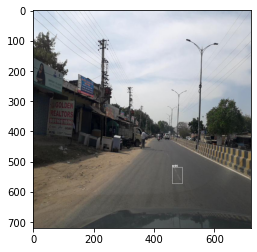

In [31]:
%cd '/content/yolov5/RoadDamageDataset/train'

random.seed(0)

class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    print(image.size)
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        print(x0)
        plotted_image.rectangle(((x0,y0), (x1,y1)))
        
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])
    
    plt.imshow(np.array(image))
    plt.show()

# Get any random annotation file 
annotation_file = '/content/yolov5/RoadDamageDataset/train/annotations/India_000010.txt'
with open(annotation_file, "r") as file:
    print(annotation_file)
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]
    print(annotation_list)

#Get the corresponding image file
image_file = annotation_file.replace("annotations", "images").replace("txt", "jpg")
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

In [32]:
# Read images and annotations
base_path = '/content/yolov5/RoadDamageDataset/train/'

images = []
annotations = []

images.append([os.path.join('images', x) for x in os.listdir(os.path.join(base_path + '/images'))])
annotations.append([os.path.join('annotations', x) for x in os.listdir(os.path.join(base_path + '/annotations')) if x[-3:] == "txt"])

images = images[0]
annotations = annotations[0]
images.sort()
annotations.sort()

print(len(images))
# Split the dataset into train-valid-test splits 
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 2)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 2)

21041


In [33]:
%cd /content/yolov5/RoadDamageDataset/train/

!mkdir images/train images/val images/test annotations/train annotations/val annotations/test

/content/yolov5/RoadDamageDataset/train


In [34]:
#Utility function to copy images in designated folders
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)
            assert False

In [35]:
# Move the images splits into their folders
move_files_to_folder(train_images, 'images/train')
move_files_to_folder(val_images, 'images/val/')
move_files_to_folder(test_images, 'images/test/')

In [36]:
# Move the annotations splits into their folders
move_files_to_folder(train_annotations, 'annotations/train/')
move_files_to_folder(val_annotations, 'annotations/val/')
move_files_to_folder(test_annotations, 'annotations/test/')

In [37]:
!wandb login --relogin cdda194a4c0ad4459d965198054dd1e59b8eef65

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [39]:
%cd /content/yolov5

/content/yolov5


In [40]:
!python train.py --hyp hyp.scratch-high.yaml --epochs 1 --data road_damage.yaml --weights yolov5s.pt --cache --project 'RDD - Yolov5' --name 'HP_demo_RDD_1ep'

wandb: Currently logged in as: bebock. Use `wandb login --relogin` to force relogin
train: weights=yolov5s.pt, cfg=, data=road_damage.yaml, hyp=hyp.scratch-high.yaml, epochs=1, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=RDD - Yolov5, name=HP_demo_RDD_1ep, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 17 (delta 9), reused 17 (delta 9), pack-reused 0
Unpacking objects: 100% (17/17), done.
From https://github.com/ultralytics/yolov5
 * [new branch]      update/bench_ci -> orig

In [41]:
%cd '/content/drive/My Drive/RDD/yolov5'

/content/drive/.shortcut-targets-by-id/1XLV_77myUQgE8im4ec1hnJFWbbn_NQFt/RDD/yolov5


In [42]:
from PIL import Image

In [43]:
model_name='/content/drive/MyDrive/RDD/yolov5/RDDYolov5/third_training_5l_100e_scrlow/weights/best.pt'
model = torch.hub.load(os.getcwd(), 'custom', source='local', path = model_name, force_reload = True)
model.conf = 0.2

INFO:yolov5:YOLOv5 🚀 v6.1-270-g6935a54 Python-3.7.13 torch-1.12.1+cu113 CPU

YOLOv5 🚀 v6.1-270-g6935a54 Python-3.7.13 torch-1.12.1+cu113 CPU

INFO:yolov5:Fusing layers... 
Fusing layers... 
INFO:yolov5:Model summary: 367 layers, 46162128 parameters, 0 gradients, 107.8 GFLOPs
Model summary: 367 layers, 46162128 parameters, 0 gradients, 107.8 GFLOPs
INFO:yolov5:Adding AutoShape... 
Adding AutoShape... 


In [44]:
!pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.1 MB 15.9 MB/s 
     |████████████████████████████████| 270 kB 54.1 MB/s 
     |████████████████████████████████| 2.3 MB 29.4 MB/s 
     |████████████████████████████████| 84 kB 2.9 MB/s 
     |████████████████████████████████| 212 kB 57.9 MB/s 
     |████████████████████████████████| 112 kB 64.5 MB/s 
     |████████████████████████████████| 54 kB 2.8 MB/s 
     |████████████████████████████████| 54 kB 3.4 MB/s 
     |████████████████████████████████| 84 kB 3.6 MB/s 
     |████████████████████████████████| 57 kB 4.6 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
     |████████████████████████████████| 80 kB 8.7 MB/s 
     |████████████████████████████████| 68 kB 7.1 MB/s 
     |████████████████████████████████| 43 kB 1.8 MB/s 
     |████████████████████████████████| 4.1 MB 40.8 MB/s 
     |████████████████████████████████| 856 kB 55

In [ ]:
import gradio as gr
def yolo(im, size=732):
    g = (size / max(im.size))  # gain
    im = im.resize((int(x * g) for x in im.size), Image.ANTIALIAS)  # resize

    results = model(im)  # inference
    results.render()  # updates results.imgs with boxes and labels
    return Image.fromarray(results.imgs[0])


inputs = gr.inputs.Image(type='pil', label="Original Image")
outputs = gr.outputs.Image(type="pil", label="Output Image")

title = 'Modèle de détection des fissures sur la route'
description = "Les meilleurs data-scientists du monde se sont réunis pour créer le plus performant des modèles de détection de fissures sur route (lien Paypal en description)"

#examples = ['/content/drive/MyDrive/RDD/LN/yolov5/RDD - Yolov5/4_training_5s_100e_scrlow/weights/image_test/Czech_000002.jpg']
gr.Interface(yolo, inputs, outputs, title=title, description=description, analytics_enabled=False).launch(
    debug=True)

/usr/local/lib/python3.7/dist-packages/gradio/inputs.py:257: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  "Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components",
/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.7/dist-packages/gradio/outputs.py:43: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  "Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components",


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().


INFO:paramiko.transport:Connected (version 2.0, client OpenSSH_7.6p1)
Connected (version 2.0, client OpenSSH_7.6p1)
INFO:paramiko.transport:Authentication (publickey) successful!
Authentication (publickey) successful!


Running on public URL: https://46826.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces: https://huggingface.co/spaces


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/gradio/routes.py", line 260, in run_predict
    fn_index, raw_input, username, session_state
  File "/usr/local/lib/python3.7/dist-packages/gradio/blocks.py", line 687, in process_api
    predictions, duration = await self.call_function(fn_index, inputs)
  File "/usr/local/lib/python3.7/dist-packages/gradio/blocks.py", line 605, in call_function
    block_fn.fn, *processed_input, limiter=self.limiter
  File "/usr/local/lib/python3.7/dist-packages/anyio/to_thread.py", line 32, in run_sync
    func, *args, cancellable=cancellable, limiter=limiter
  File "/usr/local/lib/python3.7/dist-packages/anyio/_backends/_asyncio.py", line 937, in run_sync_in_worker_thread
    return await future
  File "/usr/local/lib/python3.7/dist-packages/anyio/_backends/_asyncio.py", line 867, in run
    result = context.run(func, *args)
  File "<ipython-input-45-af2b23ef5497>", line 3, in yolo
    g = (size / max(im.size))  # gain